### What is Qformer?



![nn](./qformer_archi.png)

### Background

<p align="center">
  <img src="./transformer.png" alt="nn" width="600"/>
</p>


## 1. Self-Attention

In [1]:
import math
import torch
import torch.nn as nn


class SelfAttention(nn.Module):
    def __init__(self, seq_len, hidden_size, num_attention_heads,
                 attention_probs_dropout_probs=0.1,attention_mask=None, use_causal_mask=False):
        super().__init__()
        # hidden_size % num_attention_head must be 0

        self.seq_len = seq_len #  512
        self.hidden_size = hidden_size # 128
        self.num_attention_heads = num_attention_heads # 어텐션 헤드 개수 8
        self.attention_probs_dropout_probs = attention_probs_dropout_probs # Hyper
        self.attention_head_size = int(self.hidden_size / self.num_attention_heads) # 128 / 8 = 16
        self.all_head_size = self.num_attention_heads * self.attention_head_size # 8 * 16 = 128 → all_head_size == hidden_size

        if self.hidden_size % self.num_attention_heads != 0: # 나누어 떨어지지 않는다면 에러 발생
            raise ValueError(f'The hidden_size {self.hidden_size} is not a multiple of num_attention_head')

        # Q = X * W^Q
        # X: (batch_size, seq_len, hidden_size)
        # W^Q: (hidden_size, hidden_size), same for W^Q, W^K, W^V
        # Q: (batch_size, seq_len, hidden_size), same for Q, K, V
        self.query = nn.Linear(self.hidden_size, self.all_head_size) # (128, 128)
        self.key = nn.Linear(self.hidden_size, self.all_head_size)   # (128, 128)
        self.value = nn.Linear(self.hidden_size, self.all_head_size) # (128, 128)

        self.dropout = nn.Dropout(self.attention_probs_dropout_probs) # 0.1

        # positional embedding (Embedding 레이어 사용)
        self.position_embeddings = nn.Embedding(seq_len, hidden_size)

        # multi-head attention 연산을 위해 Q, K, V를 num_attention_heads개로 분할하는 함수
        # input x: (batch_size, seq_len, hidden_size)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, seq_len, all_head_size)
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        # (B, S) + (num_heads, head_dim) → (B, S, num_heads, head_dim)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)
        # (batch_size, num_attention_heads, seq_len, attention_head_size)
        # 순서를 바꿔주는 것 (B, H, S, D)


    def forward(
        self,
        hidden_states: torch.Tensor,          # 항상 Q는 여기서 생성 (디코더 hidden state)
        attention_mask=None,                  # 패딩 마스크
        encoder_hidden_states=None,           # Cross-Attention일 경우 K/V 소스
        use_causal_mask=False                 # 디코더 Self-Attention일 경우 True
    ):
        batch_size, seq_len, _ = hidden_states.size()

        # --- 위치 임베딩 (Q 입력에만 적용) ---
        position_ids = torch.arange(seq_len, dtype=torch.long, device=hidden_states.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)  # (B, S)
        pos_emb = self.position_embeddings(position_ids)  # (B, S, H)
        hidden_states = hidden_states + pos_emb

        # --- Q 생성 (무조건 디코더 hidden_states에서) ---
        mixed_query_layer = self.query(hidden_states)  # (B, S, all_head_size)

        # --- K, V 소스 결정 ---
        if encoder_hidden_states is None:
            # Self-Attention일 경우 → K/V도 hidden_states에서 생성
            k_input = v_input = hidden_states
        else:
            # Cross-Attention일 경우 → K/V는 encoder 출력에서 생성
            k_input = v_input = encoder_hidden_states

        mixed_key_layer = self.key(k_input)       # (B, S, all_head_size)
        mixed_value_layer = self.value(v_input)  # (B, S, all_head_size)

        # --- shape 변환 (multi-head) ---
        query_layer = self.transpose_for_scores(mixed_query_layer)  # (B, H, S, D)
        key_layer = self.transpose_for_scores(mixed_key_layer)      # (B, H, S, D)
        value_layer = self.transpose_for_scores(mixed_value_layer)  # (B, H, S, D)

        # --- Attention score 계산: QK^T / sqrt(d_k) ---
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        # (B, H, S, D) @ (B, H, D, S) → (B, H, S, S)
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # --- causal mask (디코더 Self-Attention용) ---
        if use_causal_mask:
            causal_mask = torch.tril(torch.ones_like(attention_scores, device=attention_scores.device))
            causal_mask = causal_mask.masked_fill(causal_mask == 0, float('-inf'))
            attention_scores = attention_scores + causal_mask

        # --- padding mask (인코더/디코더 공통) ---
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # --- softmax 확률화 ---
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        # 각 query 위치(q)에 대해 모든 key 위치(k)로 점수를 확률화
        attention_probs = self.dropout(attention_probs)

        # --- output 계산: softmax(QK^T) * V ---
        context_layer = torch.matmul(attention_probs, value_layer)
        # (B, H, S, S) @ (B, H, S, D) → (B, H, S, D)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        # (B, S, H, D)

        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size, )
        context_layer = context_layer.view(new_context_layer_shape)
        # (batch_size, seq_len, all_head_size)

        return context_layer, attention_probs


In [2]:
a = SelfAttention(256, 512, 8) #Seq_len , hidden_size, num_head

dummy_input = torch.randn(2, 256, 512) #B, S, H

a.forward(dummy_input)

(tensor([[[ 0.0123, -0.0130, -0.1025,  ...,  0.0099,  0.0432, -0.0314],
          [-0.0043,  0.0816,  0.0605,  ..., -0.0854,  0.0761,  0.1571],
          [ 0.0105,  0.0665, -0.0198,  ..., -0.0731,  0.1293,  0.2379],
          ...,
          [-0.0402,  0.0185, -0.0150,  ..., -0.0592,  0.0814,  0.1113],
          [-0.0188,  0.0539, -0.0851,  ..., -0.0549,  0.0376,  0.0229],
          [ 0.0403,  0.0738,  0.0213,  ..., -0.0206,  0.0256,  0.1165]],
 
         [[ 0.0419,  0.3147, -0.0298,  ...,  0.0591, -0.0493,  0.0259],
          [ 0.0242,  0.1770, -0.0014,  ..., -0.0760,  0.0065,  0.1597],
          [ 0.0122,  0.1707, -0.0092,  ..., -0.0127, -0.0718,  0.0761],
          ...,
          [-0.0164,  0.1582,  0.0026,  ...,  0.0114,  0.0059,  0.2040],
          [ 0.0460,  0.2164,  0.0060,  ...,  0.0182, -0.0339,  0.0494],
          [ 0.0955,  0.1904,  0.0277,  ..., -0.0652, -0.0647,  0.0388]]],
        grad_fn=<ViewBackward0>),
 tensor([[[[0.0046, 0.0022, 0.0022,  ..., 0.0104, 0.0091, 0.0025],


- 여기서 SelfAttention 클래스에는 Seq_len, Hidden_size, Num_head가 들어가고,
- SelfAttention의 forward에는 Batch, Seq_len, Hidden_size가 들어가는 것을 알고가자.


In [3]:
import torch
import torch.nn.functional as F

# 예제 텐서 (2x3)
x = torch.tensor([[1.0, 2.0, 3.0], # 2,3
                  [4.0, 5.0, 6.0]])
print(x.shape)

print("원본 텐서:")
print(x)

# dim=0 → 세로(열) 기준으로 softmax
print("\nSoftmax(dim=0):")
print(F.softmax(x, dim=0))  # 각 열 합이 1

# dim=1 → 가로(행) 기준으로 softmax
print("\nSoftmax(dim=1):")
print(F.softmax(x, dim=1))  # 각 행 합이 1

# dim=-1 → 마지막 차원 (여기선 dim=1과 같음)
print("\nSoftmax(dim=-1):")
print(F.softmax(x, dim=-1))


torch.Size([2, 3])
원본 텐서:
tensor([[1., 2., 3.],
        [4., 5., 6.]])

Softmax(dim=0):
tensor([[0.0474, 0.0474, 0.0474],
        [0.9526, 0.9526, 0.9526]])

Softmax(dim=1):
tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

Softmax(dim=-1):
tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


### 2. Self-Output

- 다음은 SelfOutput 입니다. 여기에는 , Hidden_size, Hidden_dropout_prob가 들어갑니다.
- 레이어가 정의되는데,LayerNorm(Dropout(Dense(x))) 가 연산됩니다.

#### Attetion

- 자 이제, Self-attention과 Self Output을 정의했으니, Self-attention을 통해, Attention 연산이 이루어진 W^Q, W^K, W^V를 활용해서 연산이 이루어집니다.

- 먼저 init에는 SelfAttetion 객체, SelfOutput객체가 선언되고, forward를 통해 Attention 연산된 것이
- 다시, Self Output을 통과하여 Attention Output이 생성되게 됩니다. 이때 출력 결과는 (B, S, H)입니다.

<p align="center">
  <img src="./Multi-head_add_norm.png" alt="nn" width="200"/>
</p>


In [4]:
class SelfOutput(nn.Module):
    def __init__(self, hidden_size, hidden_dropout_prob): #(512, 0.1)
        super().__init__()
        self.hidden_size = hidden_size  #512
        self.hidden_dropout_prob = hidden_dropout_prob #0.1
        self.dense = nn.Linear(self.hidden_size, self.hidden_size) # 512, 512
        self.layernorm = nn.LayerNorm(self.hidden_size) #512
        self.dropout = nn.Dropout(self.hidden_dropout_prob) #0.1

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor: #인자가 Tensor로 들어가야함을 의미
        hidden_states = self.dense(hidden_states) #512
        hidden_states = self.dropout(hidden_states) #512
        hidden_states = self.layernorm(hidden_states + input_tensor) # Residual + LN
        return hidden_states


class Attention(nn.Module):
    def __init__(self, seq_len, hidden_size, num_attention_heads, hidden_dropout_prob=0.1, use_causal_mask=False):
        super().__init__()
        self.self = SelfAttention(seq_len, hidden_size, num_attention_heads, hidden_dropout_prob)
        self.output = SelfOutput(hidden_size, hidden_dropout_prob)
        self.use_causal_mask = use_causal_mask

    def forward(self, hidden_states, attention_mask=None,
                encoder_hidden_states=None, use_causal_mask=None, return_scores=False):
        if use_causal_mask is None:
            use_causal_mask = self.use_causal_mask

        # SelfAttention 실행
        context_layer, attention_probs = self.self(
            hidden_states,
            attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            use_causal_mask=use_causal_mask
        )

        # Output 모듈 (Residual + Norm)
        attention_output = self.output(context_layer, hidden_states)

        # 기본은 attention_output만 반환
        if return_scores:
            return attention_output, attention_probs
        else:
            return attention_output


In [5]:
# 더미 입력 생성 (batch=2, seq_len=4, hidden_size=128)
x = torch.randn(2, 4, 128)# hidden_states
mask = None                          # attention_mask (없음)

# Attention 모듈 초기화
attn = Attention(seq_len=4, hidden_size=128, num_attention_heads=8, hidden_dropout_prob=0.1)

# Forward 실행
out = attn(x, mask)

print("\n[Main] Attention 출력 shape:", out.shape)



[Main] Attention 출력 shape: torch.Size([2, 4, 128])


### Feed Forward Network

- 다음은, Feed Forward Network 구현입니다.
- 앞서 만들어 놨던, Attention 연산이 끝난 결과 (B, S, H)를 인풋으로 받아서 레이어를 통과합니다.

- FFN에서는 활성화함수를 걸쳐 Dimension을 확장했다가 다시 축소하는 과정이 포함되는데, 때문에 Intermediate 클래스가 활용됩니다.

- 앞서 hidden_size를 128로 정의했고, intermediate_size는 임의로 256까지 늘릴 수 있겠습니다.
- hidden states는 (B, S, H)라는 것을 잊지 말아야합니다.


<p align="center">
  <img src="./encoder2.png" alt="nn" width="200"/>
</p>


In [6]:
class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.hidden_size = hidden_size # 128
        self.intermediate_size = intermediate_size #256

        self.dense = nn.Linear(self.hidden_size, self.intermediate_size) # 128, 256
        self.relu = nn.ReLU() # ReLU

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:

        hidden_states = self.dense(hidden_states)
        hidden_states = self.relu(hidden_states)

        return hidden_states


class Output(nn.Module):
    def __init__(self, hidden_size, intermediate_size, hidden_dropout_prob=0.1):
        super().__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)  # 차원 축소  256 -> 128
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)   # 정규화
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):

        hidden_states = self.dense(hidden_states) # (B, S, H) (2, 512, 128) Dense
        hidden_states = self.dropout(hidden_states) # (B, S, H) (2, 252, 128) Dropout (Attention output)

        # Residual connection (skip connection) + LayerNorm
        hidden_states = self.LayerNorm(hidden_states + input_tensor) # ADD & Norm connection Hidden_state + input_tensor(attention)

        return hidden_states

#### 최종 ###
class Layer(nn.Module):
    def __init__(self, seq_len=512, hidden_size=128, intermediate_size=256, num_attention_heads=8, hidden_dropout_prob=0.1):
        super().__init__()
        # Attention 초기화 시 인자 전달
        self.attention = Attention(seq_len, hidden_size, num_attention_heads, hidden_dropout_prob)  #Self Attention -> Self Output (B,S,H) (2, 512, 128)
        self.intermediate = Intermediate(hidden_size, intermediate_size)# FFN 확장 (Relu Dense -> ReLU 128 -> 256) (2, 512, 256)
        self.output = Output(hidden_size, intermediate_size, hidden_dropout_prob) # FFN 축소 + add  (2, 512, 256) -> (2,512, 128) + Attention_tensor

    def forward(self, hidden_states, attention_mask=None, return_scores=False):
        # print("\n===== Layer 시작 =====")
        # print("[Layer] 입력:", hidden_states.shape)


        if return_scores:
            attention_output, attn_scores = self.attention(
                hidden_states, attention_mask, return_scores=True
            )
        else:
            attention_output = self.attention(hidden_states, attention_mask)


        # print("[Layer] Attention 출력:", attention_output.shape)

        intermediate_output = self.intermediate(attention_output)
        # print("[Layer] Intermediate 출력:", intermediate_output.shape)

        encoder_output = self.output(intermediate_output, attention_output)
        # print("[Layer] Output 출력:", encoder_output.shape)
        # print("===== Layer 종료 =====\n")


        if return_scores:
            return encoder_output, attn_scores
        return encoder_output


In [7]:
# 더미 입력 (batch=2, seq_len=4, hidden_size=128)
x = torch.randn(2, 4, 128)   # hidden_states
mask = None                  # attention_mask

# Layer 모듈 초기화
layer = Layer(seq_len=4, hidden_size=128, intermediate_size=256, num_attention_heads=8, hidden_dropout_prob=0.1)

# Forward 실행
out = layer(x, mask)

print("\n[Main] Layer 최종 출력 shape:", out.shape)



[Main] Layer 최종 출력 shape: torch.Size([2, 4, 128])


##### 이제 인코더 블록 N개중 1개를 완성했습니다.

- 이제 이 Layer 블록을 N번 확장하는 Encoder class를 최종적으로 정의하겠습니다.


<p align="center">
  <img src="./Encoder_last.png" alt="nn" width="200"/>
</p>


In [8]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_layers=6, hidden_size=128, intermediate_size=256, hidden_dropout_prob=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            Layer()
            for _ in range(num_layers)
        ])

    def forward(self, hidden_states, attention_mask=None,return_scores=False):

        all_scores=[]
        for layer in self.layers:
            if return_scores:
                hidden_states, attn_scores = layer(hidden_states, attention_mask, return_scores=True)
                all_scores.append(attn_scores)
            else:
                hidden_states = layer(hidden_states, attention_mask)

        if return_scores:
            return hidden_states, all_scores
        return hidden_states





x = torch.randn(2, 512, 128)

encoder = Encoder(num_layers=6, hidden_size=128, intermediate_size=256, hidden_dropout_prob=0.1)

output = encoder(x)

print(output)


tensor([[[ 0.1083, -1.0979,  0.8030,  ...,  0.2923,  1.4570,  0.2861],
         [ 1.4497,  1.0936,  0.4410,  ...,  0.3178, -0.1603, -0.9123],
         [-1.3219, -0.9039, -1.6826,  ...,  0.7174, -0.6331,  1.7299],
         ...,
         [ 0.8178, -0.4815, -0.6717,  ..., -0.4225, -0.8402,  1.1496],
         [ 0.6130, -0.4553, -1.1381,  ...,  0.0618, -0.5257, -1.7291],
         [ 0.2922,  0.8310, -1.1567,  ...,  1.0667,  0.8600, -0.5424]],

        [[ 1.4376,  1.3358, -0.3236,  ...,  0.6464, -0.9064, -1.0030],
         [ 0.2752,  0.3890, -0.2150,  ...,  0.3324,  0.3265, -0.2051],
         [ 1.7896,  2.0476, -0.5607,  ..., -1.9814,  1.1658, -1.0433],
         ...,
         [ 0.4263,  1.0421,  0.2555,  ...,  0.5555, -0.8351,  0.2938],
         [ 0.4340,  0.2244, -1.7027,  ..., -0.6738, -0.0301,  0.7584],
         [ 1.6168,  0.2523,  1.7681,  ...,  1.3947,  0.6252,  0.4472]]],
       grad_fn=<NativeLayerNormBackward0>)


<p align="center">
    <img src="./Decoder.png" alt="nn" width="200">
</p>

### Decoder

- 이제 디코더를 구현해야 합니다.
- 디코더는 1개의 마스크 된 멀티 헤드 셀프 어텐션과 1개의 마스크 되지 않은 Cross Attention 연산이 일어납니다.

In [9]:
import torch
import torch.nn as nn

class DecoderLayer(nn.Module):
    def __init__(self, seq_len=512, hidden_size=128, intermediate_size=256,
                 num_attention_heads=8, hidden_dropout_prob=0.1):
        super().__init__()
        self.self_attention = Attention(seq_len, hidden_size, num_attention_heads,
                                        hidden_dropout_prob, use_causal_mask=True)
        self.cross_attention = Attention(seq_len, hidden_size, num_attention_heads,
                                         hidden_dropout_prob, use_causal_mask=False)
        self.intermediate = Intermediate(hidden_size, intermediate_size)
        self.output = Output(hidden_size, intermediate_size, hidden_dropout_prob)

    def forward(self, hidden_states, encoder_output,
                self_attention_mask=None, cross_attention_mask=None,
                return_scores=False):
        if return_scores:
            self_attn_out, self_scores = self.self_attention(
                hidden_states, self_attention_mask, return_scores=True
            )
            cross_attn_out, cross_scores = self.cross_attention(
                self_attn_out, cross_attention_mask,
                encoder_hidden_states=encoder_output,
                return_scores=True
            )
        else:
            self_attn_out = self.self_attention(hidden_states, self_attention_mask)
            cross_attn_out = self.cross_attention(
                self_attn_out, cross_attention_mask, encoder_hidden_states=encoder_output
            )

        intermediate_output = self.intermediate(cross_attn_out)
        layer_output = self.output(intermediate_output, cross_attn_out)

        if return_scores:
            return layer_output, (self_scores, cross_scores)
        return layer_output


class Decoder(nn.Module):
    def __init__(self, num_layers=6, seq_len=512, hidden_size=128,
                 intermediate_size=256, num_attention_heads=8, hidden_dropout_prob=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer()
            for _ in range(num_layers)
        ])

    def forward(self, hidden_states, encoder_output,
                self_attention_mask=None, cross_attention_mask=None,
                return_scores=False):
        all_self_scores, all_cross_scores = ([] for _ in range(2)) if return_scores else (None, None)

        for layer in self.layers:
            if return_scores:
                hidden_states, (self_scores, cross_scores) = layer(
                    hidden_states, encoder_output,
                    self_attention_mask, cross_attention_mask,
                    return_scores=True
                )
                all_self_scores.append(self_scores)
                all_cross_scores.append(cross_scores)
            else:
                hidden_states = layer(hidden_states, encoder_output,
                                      self_attention_mask, cross_attention_mask)

        if return_scores:
            return hidden_states, all_self_scores, all_cross_scores
        return hidden_states




In [10]:
# 더미 입력
x_enc = torch.randn(2, 512, 128)   # Encoder 입력
x_dec = torch.randn(2, 512, 128)   # Decoder 입력

# Encoder
encoder = Encoder(num_layers=2, hidden_size=128, intermediate_size=256)
enc_output = encoder(x_enc)

# Decoder
decoder = Decoder(num_layers=2, hidden_size=128, intermediate_size=256, num_attention_heads=8)
dec_output = decoder(x_dec, enc_output)

print("Encoder 출력:", enc_output.shape)
print("Decoder 출력:", dec_output.shape)


Encoder 출력: torch.Size([2, 512, 128])
Decoder 출력: torch.Size([2, 512, 128])


### 완성했습니다.

- 이제 실제 MNIST 데이터를 통해 연산이 이루어지는 것을 확인해보도록하겠습니다.

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

# ---- 1. 데이터 로딩 ----
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False)

# ---- 2. Patch Embedding ----
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_chans=1, hidden_size=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, hidden_size,
                              kernel_size=patch_size, stride=patch_size)
        # Conv2d로 패치 분할 + flatten projection 동시에 가능

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)   # (B, hidden_size, H/patch, W/patch)
        x = x.flatten(2)   # (B, hidden_size, N_patches)
        x = x.transpose(1, 2)  # (B, N_patches, hidden_size)
        return x

# ---- 3. 예제 실행 ----
patch_embed = PatchEmbedding(img_size=28, patch_size=7, in_chans=1, hidden_size=128)

images, _ = next(iter(loader))   # (B, 1, 28, 28)
x_enc = patch_embed(images)      # (B, N_patches, HIDDEN)
print("Encoder 입력 shape:", x_enc.shape)  # (2, 16, 128)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]

Encoder 입력 shape: torch.Size([2, 16, 128])


In [12]:
# Encoder 실행 (어텐션 스코어까지 반환)
encoder = Encoder(num_layers=2, hidden_size=128, intermediate_size=256)
enc_output, enc_scores = encoder(x_enc, return_scores=True)

# Decoder 실행 (어텐션 스코어까지 반환)
x_dec = torch.randn_like(x_enc)
decoder = Decoder(num_layers=2, hidden_size=128, intermediate_size=256, num_attention_heads=8)
dec_output, self_scores, cross_scores = decoder(x_dec, enc_output, return_scores=True)

print("Encoder 출력:", enc_output.shape)      # (2, 16, 128)
print("Decoder 출력:", dec_output.shape)      # (2, 16, 128)
print("Self-Attn Score:", self_scores[0].shape)   # (2, H, 16, 16)
print("Cross-Attn Score:", cross_scores[0].shape) # (2, H, 16, 16)


Encoder 출력: torch.Size([2, 16, 128])
Decoder 출력: torch.Size([2, 16, 128])
Self-Attn Score: torch.Size([2, 8, 16, 16])
Cross-Attn Score: torch.Size([2, 8, 16, 16])


In [13]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
img, label = mnist[7]  # (1, 28, 28)


In [14]:
patch_size = 7
img_np = img.squeeze(0).numpy()  # (28, 28)
patches = img_np.reshape(28//patch_size, patch_size, 28//patch_size, patch_size)
patches = patches.transpose(0, 2, 1, 3).reshape(-1, patch_size*patch_size)
x_enc = torch.randn(1, patches.shape[0], 128)  # (B, seq_len, hidden_dim)


encoder = Encoder(num_layers=6, hidden_size=64, intermediate_size=128)
enc_output, enc_scores = encoder(x_enc, return_scores=True)


attn_map = enc_scores[0][0, 0]  # 첫 레이어, 첫 헤드, (seq_len, seq_len)
attn_map = attn_map[0].detach().cpu().numpy()  # 첫 query 토큰이 보는 분포


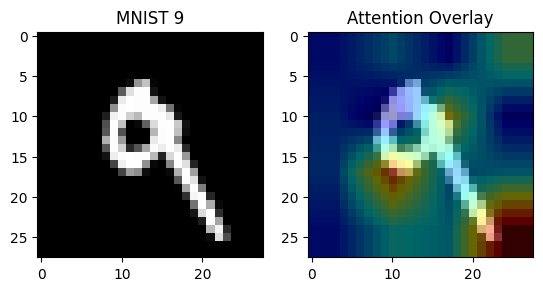

In [15]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

grid_size = int(np.sqrt(attn_map.shape[0]))
heatmap = attn_map.reshape(grid_size, grid_size)

# 원본 28x28 크기로 resize
heatmap = cv2.resize(heatmap, (28, 28))
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

colored_heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
img_gray = np.uint8(img_np*255)
img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

overlay = cv2.addWeighted(img_rgb, 0.6, colored_heatmap, 0.4, 0)

plt.subplot(1,2,1); plt.imshow(img_np, cmap="gray"); plt.title(f"MNIST {label}")
plt.subplot(1,2,2); plt.imshow(overlay[:,:,::-1]); plt.title("Attention Overlay")
plt.show()


In [16]:
class QFormerLayer(nn.Module):
    def __init__(self, seq_len=512, hidden_size=128, intermediate_size=256,
                 num_attention_heads=8, hidden_dropout_prob=0.1, num_query_tokens=32):
        super().__init__()
        # 학습 가능한 Query Token
        self.query_tokens = nn.Parameter(torch.randn(1, num_query_tokens, hidden_size))

        # Query Self-Attention
        self.self_attention = Attention(seq_len=num_query_tokens, hidden_size=hidden_size,
                                        num_attention_heads=num_attention_heads,
                                        hidden_dropout_prob=hidden_dropout_prob,
                                        use_causal_mask=False)

        # Cross Attention (Q=query, K/V=encoder_output)
        self.cross_attention = Attention(seq_len=num_query_tokens, hidden_size=hidden_size,
                                         num_attention_heads=num_attention_heads,
                                         hidden_dropout_prob=hidden_dropout_prob,
                                         use_causal_mask=False)

        # Feed-Forward
        self.intermediate = Intermediate(hidden_size, intermediate_size)
        self.output = Output(hidden_size, intermediate_size, hidden_dropout_prob)

    def forward(self, encoder_output, attention_mask=None, return_scores=False):
        batch_size = encoder_output.size(0)

        # Query token 확장 (batch dimension 맞추기)
        query = self.query_tokens.expand(batch_size, -1, -1)  # (B, Nq, H)

        # 1. Query Self-Attention
        q_out = self.self_attention(query, attention_mask, return_scores=return_scores)

        if return_scores:
            q_out, self_scores = q_out
        else:
            self_scores = None

        # 2. Cross Attention (Q=query, K/V=encoder_output)
        cross_out = self.cross_attention(q_out, attention_mask,
                                         encoder_hidden_states=encoder_output,
                                         return_scores=return_scores)

        if return_scores:
            cross_out, cross_scores = cross_out
        else:
            cross_scores = None

        # 3. Feed Forward
        inter = self.intermediate(cross_out)
        out = self.output(inter, cross_out)

        if return_scores:
            return out, (self_scores, cross_scores)
        return out


In [17]:
class QFormer(nn.Module):
    def __init__(self, num_layers=4, seq_len=512, hidden_size=128,
                 intermediate_size=256, num_attention_heads=8,
                 hidden_dropout_prob=0.1, num_query_tokens=32):
        super().__init__()
        self.layers = nn.ModuleList([
            QFormerLayer(seq_len, hidden_size, intermediate_size,
                         num_attention_heads, hidden_dropout_prob,
                         num_query_tokens)
            for _ in range(num_layers)
        ])

    def forward(self, encoder_output, attention_mask=None, return_scores=False):
        query_output = None
        all_scores = []
        for layer in self.layers:
            if return_scores:
                query_output, scores = layer(encoder_output, attention_mask, return_scores=True)
                all_scores.append(scores)
            else:
                query_output = layer(encoder_output, attention_mask, return_scores=False)

        if return_scores:
            return query_output, all_scores
        return query_output


In [18]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# ===== 1. Image Encoder =====
class ImageEncoder(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        resnet = resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # (B, 512, H/32, W/32)
        self.proj = nn.Linear(512, hidden_size)

    def forward(self, images):
        feat_map = self.backbone(images)  # (B, 512, H', W')
        feat_map = feat_map.flatten(2).permute(0, 2, 1)  # (B, seq_len, 512)
        return self.proj(feat_map)  # (B, seq_len, hidden_size)

# ===== 2. Q-Former =====
class QFormerWrapper(nn.Module):
    def __init__(self, qformer):
        super().__init__()
        self.qformer = qformer

    def forward(self, img_embeds):
        return self.qformer(img_embeds)  # (B, Nq, H)

# ===== 3. Image Captioning Model =====
class ImageCaptioningModel(nn.Module):
    def __init__(self, qformer, hidden_size=256, num_query_tokens=32):
        super().__init__()
        self.img_encoder = ImageEncoder(hidden_size)
        self.qformer = QFormerWrapper(qformer)

        # GPT2 decoder (LM Head)
        self.text_decoder = GPT2LMHeadModel.from_pretrained("gpt2")

        # Query → GPT2 input projection
        self.query_proj = nn.Linear(hidden_size, self.text_decoder.config.n_embd)

    def forward(self, images, input_ids, attention_mask=None, labels=None):
        # 1. Image features
        img_embeds = self.img_encoder(images)  # (B, seq_len, H)

        # 2. Q-Former
        q_embeds = self.qformer(img_embeds)  # (B, Nq, H)

        # 3. Projection to GPT2 space
        q_proj = self.query_proj(q_embeds)  # (B, Nq, n_embd)

        # 4. GPT2 forward (prefix conditioning)
        outputs = self.text_decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=q_proj,  # Cross-attention context
            labels=labels
        )
        return outputs


In [19]:
def generate_caption(model, image, tokenizer, max_length=20):
    img = image.unsqueeze(0)  # (1, C, H, W)
    img_embeds = model.img_encoder(img)
    q_embeds = model.qformer(img_embeds)
    q_proj = model.query_proj(q_embeds)

    # GPT2 generate
    outputs = model.text_decoder.generate(
        input_ids=tokenizer.bos_token_id * torch.ones((1,1), dtype=torch.long),
        max_length=max_length,
        encoder_hidden_states=q_proj
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [20]:
!pip install datasets

In [21]:
from torchvision import datasets, transforms

mnist = datasets.MNIST(root="./data", train=True, download=True,
                       transform=transforms.ToTensor())

# 예시: "This is digit X"
image, label = mnist[0]
caption = f"This is digit {label}"
print(caption)


This is digit 5


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1. 데이터셋 (MNIST → "This is digit X")
class MnistCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, root="./data", train=True):
        self.mnist = datasets.MNIST(
            root=root, train=train, download=True,
            transform=transforms.ToTensor()
        )

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        caption = f"This is digit {label}"
        return image, caption, label

dataset = MnistCaptionDataset()
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 2. 간단한 이미지 인코더 (CNN → feature seq)
class SimpleImageEncoder(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2),  # (1,28,28) → (32,13,13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2), # (64,6,6)
            nn.ReLU(),
        )
        self.proj = nn.Linear(64*6*6, hidden_dim)

    def forward(self, x):
        feat = self.conv(x)                 # (B,64,6,6)
        feat = feat.flatten(1)              # (B, 64*6*6)
        feat = self.proj(feat)              # (B, hidden_dim)
        return feat.unsqueeze(1)            # (B, seq_len=1, H)

# 3. Q-Former (Encoder-Decoder)
class QFormer(nn.Module):
    def __init__(self, encoder, decoder, hidden_size=128, vocab_size=20):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, img, tgt_ids):
        enc_out = self.encoder(img)              # (B, 1, H)
        dec_in = self.embed(tgt_ids)             # (B, L, H)
        dec_out = self.decoder(dec_in, enc_out)  # (B, L, H)
        logits = self.fc_out(dec_out)            # (B, L, vocab_size)
        return logits

# === 사용 예시 ===
img_encoder = SimpleImageEncoder()
encoder = Encoder(num_layers=2, hidden_size=128, intermediate_size=256)
decoder = Decoder(num_layers=2, hidden_size=128, intermediate_size=256, num_attention_heads=8)
model = QFormer(encoder, decoder)

dummy_imgs, dummy_caps, labels = next(iter(loader))
print("이미지 batch:", dummy_imgs.shape)
print("예시 캡션:", dummy_caps)


이미지 batch: torch.Size([8, 1, 28, 28])
예시 캡션: ('This is digit 3', 'This is digit 7', 'This is digit 7', 'This is digit 3', 'This is digit 3', 'This is digit 2', 'This is digit 9', 'This is digit 4')


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ==========================
# 1. 데이터셋
# ==========================
class MnistCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, root="./data", train=True):
        self.mnist = datasets.MNIST(
            root=root, train=train, download=True,
            transform=transforms.ToTensor()
        )
        # 간단 토크나이저 (단어 → 인덱스)
        self.vocab = {
            "[PAD]":0, "[SOS]":1, "[EOS]":2,
            "This":3, "is":4, "digit":5,
            "0":6,"1":7,"2":8,"3":9,"4":10,"5":11,"6":12,"7":13,"8":14,"9":15
        }
        self.inv_vocab = {v:k for k,v in self.vocab.items()}

    def encode(self, caption, max_len=6):
        tokens = caption.split()  # ["This", "is", "digit", "3"]
        ids = [self.vocab["[SOS]"]] + [self.vocab[t] for t in tokens] + [self.vocab["[EOS]"]]
        ids += [self.vocab["[PAD]"]] * (max_len - len(ids))
        return torch.tensor(ids[:max_len])

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        caption = f"This is digit {label}"
        cap_ids = self.encode(caption)
        return image, cap_ids, label

dataset = MnistCaptionDataset()
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ==========================
# 2. 간단한 이미지 인코더
# ==========================
class SimpleImageEncoder(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2),  # (1,28,28) → (32,13,13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2), # (64,6,6)
            nn.ReLU(),
        )
        self.proj = nn.Linear(64*6*6, hidden_dim)

    def forward(self, x):
        feat = self.conv(x)                 # (B,64,6,6)
        feat = feat.flatten(1)              # (B, 2304)
        feat = self.proj(feat)              # (B, 128)
        return feat.unsqueeze(1)            # (B, seq_len=1, H)

# ==========================
# 3. Transformer Encoder/Decoder (앞서 만든 코드 사용)
# ==========================
# Encoder / Decoder는 이미 정의했다고 가정
# Encoder(num_layers=2, hidden_size=128, intermediate_size=256)
# Decoder(num_layers=2, hidden_size=128, intermediate_size=256, num_attention_heads=8)

# ==========================
# 4. Q-Former
# ==========================
class QFormer(nn.Module):
    def __init__(self, img_encoder, encoder, decoder, hidden_size=128, vocab_size=20):
        super().__init__()
        self.img_encoder = img_encoder
        self.encoder = encoder
        self.decoder = decoder
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, img, tgt_ids):
        # 이미지 인코딩
        img_feat = self.img_encoder(img)         # (B, 1, H)
        enc_out = self.encoder(img_feat)         # (B, 1, H)

        # 텍스트 입력 (teacher forcing)
        dec_in = self.embed(tgt_ids)             # (B, L, H)
        dec_out = self.decoder(dec_in, enc_out)  # (B, L, H)

        # 로짓 출력
        logits = self.fc_out(dec_out)            # (B, L, vocab_size)
        return logits

# ==========================
# 5. 학습 루프
# ==========================
device = "cuda" if torch.cuda.is_available() else "cpu"

img_encoder = SimpleImageEncoder().to(device)
encoder = Encoder(num_layers=2, hidden_size=128, intermediate_size=256).to(device)
decoder = Decoder(num_layers=2, hidden_size=128, intermediate_size=256, num_attention_heads=8).to(device)
model = QFormer(img_encoder, encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # PAD 무시
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):  # toy 학습 → 2 epoch만
    cnt =0
    for imgs, cap_ids, _ in loader:
        imgs, cap_ids = imgs.to(device), cap_ids.to(device)
        cnt+=1
        # 입력/라벨 분리 (teacher forcing)
        inputs = cap_ids[:, :-1]    # (B, L-1)
        targets = cap_ids[:, 1:]    # (B, L-1)

        logits = model(imgs, inputs)
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

        if cnt %50==0:
            print(f"Now Loss {loss}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f}")

# ==========================
# 6. 테스트 (샘플 캡션 생성)
# ==========================
def generate_caption(model, img, max_len=6, inv_vocab=None):
    if inv_vocab is None:
        inv_vocab = dataset.inv_vocab  # 전역 dataset에서 가져오기

    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        enc_out = model.img_encoder(img)
        enc_out = model.encoder(enc_out)

        tgt = torch.tensor([[1]], device=device)  # [SOS]
        caption = []

        for _ in range(max_len):
            dec_in = model.embed(tgt)
            dec_out = model.decoder(dec_in, enc_out)
            logits = model.fc_out(dec_out[:, -1])
            next_token = logits.argmax(-1).item()

            if next_token == 2:  # [EOS]
                break

            word = inv_vocab.get(next_token, "?")
            caption.append(word)

            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=1)

    return " ".join(caption)




Now Loss 0.4821760058403015
Now Loss 0.12506535649299622
Now Loss 0.11953604221343994
Now Loss 0.09217195212841034
Now Loss 0.06882687658071518
Now Loss 0.01608704961836338
Now Loss 0.0458444245159626
Now Loss 0.05528935045003891
Now Loss 0.02244558371603489
Now Loss 0.040510013699531555
Now Loss 0.014737230725586414
Now Loss 0.05860382318496704
Now Loss 0.04797273129224777
Now Loss 0.024442197754979134
Now Loss 0.06807726621627808
Now Loss 0.04614121466875076
Now Loss 0.0051010241732001305
Now Loss 0.027383258566260338
Now Loss 0.01825672760605812
Now Loss 0.006850679405033588
Now Loss 0.00693421671167016
Now Loss 0.002448323182761669
Now Loss 0.008848927915096283
Now Loss 0.027826432138681412
Now Loss 0.033624403178691864
Now Loss 0.011920647695660591
Now Loss 0.026332059875130653
Now Loss 0.038080424070358276
Now Loss 0.002423528116196394
Now Loss 0.00420661736279726
Now Loss 0.013034289702773094
Now Loss 0.06543217599391937
Now Loss 0.006603685673326254
Now Loss 0.01396829169243574

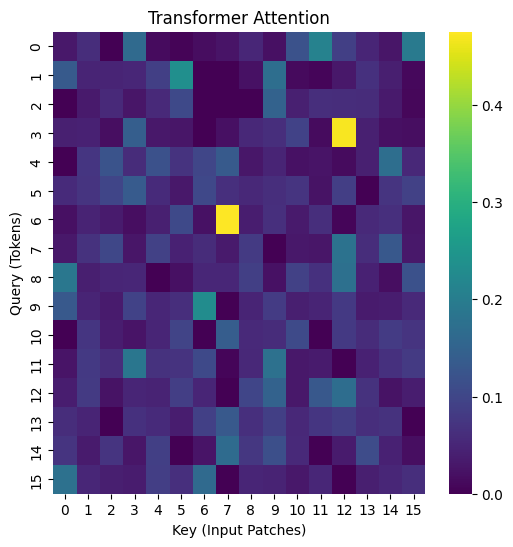

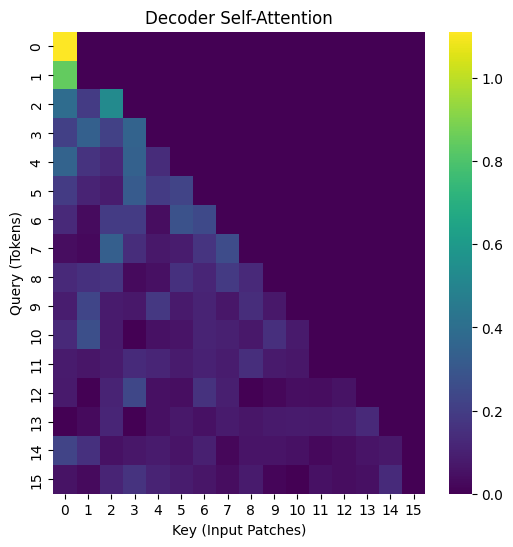

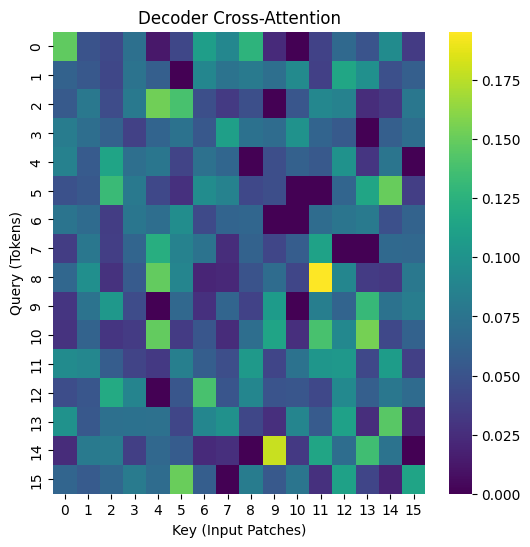

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_map(attn_map, title="Attention Map"):
    plt.figure(figsize=(6,6))
    sns.heatmap(attn_map, cmap="viridis")
    plt.title(title)
    plt.xlabel("Key (Input Patches)")
    plt.ylabel("Query (Tokens)")
    plt.show()

# 예: 첫 번째 배치, 첫 번째 헤드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성
encoder = Encoder(num_layers=2, hidden_size=128, intermediate_size=256).to(device)
qformer = Decoder(num_layers=2, hidden_size=128, intermediate_size=256, num_attention_heads=8).to(device)

# 입력도 GPU로 이동
x_enc = x_enc.to(device)
x_dec = x_dec.to(device)
# 실행
enc_output, enc_scores = encoder(x_enc, return_scores=True)
dec_output, self_scores, cross_scores = qformer(x_dec, enc_output, return_scores=True)

# 첫 번째 레이어, 첫 번째 헤드 시각화
plot_attention_map(enc_scores[0][0,0].detach().cpu().numpy(), "Transformer Attention")
plot_attention_map(self_scores[0][0,0].detach().cpu().numpy(), "Decoder Self-Attention")
plot_attention_map(cross_scores[0][0,0].detach().cpu().numpy(), "Decoder Cross-Attention")


In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, ViTModel

# ============================================================
# 1. Encoders
# ============================================================
class TextEncoder(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super().__init__()
        self.model = BertModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask=None):
        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return out.last_hidden_state  # (B, L, D)


class ImageEncoder(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224", out_dim=768):
        super().__init__()
        self.model = ViTModel.from_pretrained(model_name)
        self.proj = nn.Linear(self.model.config.hidden_size, out_dim)

    def forward(self, x):
        out = self.model(pixel_values=x).last_hidden_state  # (B, N, D)
        return self.proj(out)


# ============================================================
# 2. Q-Former
# ============================================================
class QFormer(nn.Module):
    def __init__(self, hidden_dim=768, num_queries=16, num_layers=4, num_heads=8):
        super().__init__()
        self.query_tokens = nn.Parameter(torch.randn(1, num_queries, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mlp_itm = nn.Linear(hidden_dim, 2)  # ITM binary classifier

    def forward(self, img_feat, txt_feat):
        B = img_feat.size(0)
        q = self.query_tokens.expand(B, -1, -1)
        context = torch.cat([img_feat, txt_feat], dim=1)
        out = self.encoder(torch.cat([q, context], dim=1))
        q_out = out[:, :q.size(1), :]  # query part
        return q_out


# ============================================================
# 3. Full Model (Encoders + QFormer)
# ============================================================
class BLIPMini(nn.Module):
    def __init__(self, hidden_dim=768):
        super().__init__()
        self.img_encoder = ImageEncoder(out_dim=hidden_dim)
        self.txt_encoder = TextEncoder()
        self.qformer = QFormer(hidden_dim=hidden_dim)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

        # projection for contrastive (ITC)
        self.img_proj = nn.Linear(hidden_dim, hidden_dim)
        self.txt_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, imgs, captions):
        B = imgs.size(0)

        # ----- Encode -----
        img_feat = self.img_encoder(imgs)   # (B,N,D)
        tok = self.tokenizer(
            captions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            return_token_type_ids=False
        )
        tok = {k: v.to(imgs.device) for k, v in tok.items()}
        txt_feat = self.txt_encoder(**tok)  # (B,L,D)

        # ----- QFormer -----
        q_out = self.qformer(img_feat, txt_feat)  # (B,num_queries,D)
        q_pooled = q_out.mean(dim=1)              # pooled query (B,D)

        # ----- ITC -----
        img_cls = img_feat.mean(dim=1)  # mean pooling
        txt_cls = txt_feat.mean(dim=1)
        img_emb = F.normalize(self.img_proj(img_cls), dim=-1)
        txt_emb = F.normalize(self.txt_proj(txt_cls), dim=-1)
        sim = img_emb @ txt_emb.t()  # (B,B)
        labels = torch.arange(B, device=imgs.device)
        itc_loss = (F.cross_entropy(sim, labels) + F.cross_entropy(sim.t(), labels)) / 2

        # ----- ITM -----
        neg_idx = torch.randperm(B).to(imgs.device)

        pos_logits = self.qformer.mlp_itm(self.qformer(img_feat, txt_feat).mean(1))   # (B,2)
        neg_logits = self.qformer.mlp_itm(self.qformer(img_feat[neg_idx], txt_feat).mean(1))  # (B,2)

        itm_logits = torch.cat([pos_logits, neg_logits], dim=0)  # (2B,2)
        itm_labels = torch.cat([
            torch.ones(B),   # positive = 1
            torch.zeros(B)   # negative = 0
        ]).long().to(imgs.device)

        itm_loss = F.cross_entropy(itm_logits, itm_labels)

        return itc_loss, itm_loss


# ============================================================
# Training Loop
# ============================================================
model = BLIPMini().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(5):
    for (imgs, _), captions in loader:  # loader = (image, caption) 쌍
        imgs = imgs.cuda()
        itc_loss, itm_loss = model(imgs, captions)
        loss = itc_loss + itm_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | ITC: {itc_loss.item():.4f} | ITM: {itm_loss.item():.4f}")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | ITC: 1.3305 | ITM: 0.7042
Epoch 2 | ITC: 1.2568 | ITM: 0.6891
Epoch 3 | ITC: 1.0750 | ITM: 0.7136
Epoch 4 | ITC: 1.0130 | ITM: 0.6897
Epoch 5 | ITC: 0.9734 | ITM: 0.7002


In [119]:
torch.save({
    "img_encoder": model.img_encoder.state_dict(),
    "txt_encoder": model.txt_encoder.state_dict(),
    "qformer": model.qformer.state_dict(),
}, "blipmini_pretrained.pth")


In [ ]:

class QFormerConditioner(nn.Module):
    def __init__(self, hidden_dim=768, sd_hidden_dim=768):
        super().__init__()
        self.img_encoder = ImageEncoder(out_dim=hidden_dim)
        self.txt_encoder = TextEncoder()
        self.qformer = QFormer(hidden_dim=hidden_dim)
        self.proj = nn.Linear(hidden_dim, sd_hidden_dim)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def forward(self, imgs, captions):
        # 이미지 피처
        img_feat = self.img_encoder(imgs)  # (B, N, D)

        # 텍스트 피처
        tok = self.tokenizer(
            captions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            return_token_type_ids=False
        )
        tok = {k: v.to(imgs.device) for k, v in tok.items()}
        txt_feat = self.txt_encoder(**tok)  # (B, L, D)

        # Q-Former Cross-Attention
        q_out = self.qformer(img_feat, txt_feat)  # (B, num_queries, D)
        return self.proj(q_out)  # (B, num_queries, 768)
# ============================================================

In [122]:

# ============================================================
# 6. Step 2: Diffusion with Conditioner
# ============================================================
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").cuda()
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").cuda()
noise_scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

conditioner = QFormerConditioner().cuda()
pretrained = torch.load("blipmini_pretrained.pth")
conditioner.img_encoder.load_state_dict(pretrained["img_encoder"])
conditioner.txt_encoder.load_state_dict(pretrained["txt_encoder"])
conditioner.qformer.load_state_dict(pretrained["qformer"])

optimizer = optim.Adam(list(conditioner.parameters())+list(unet.parameters()), lr=1e-4)

for epoch in range(50):  # 예시 1 epoch
    for (imgs, _), captions in tqdm(loader):
        imgs = imgs.cuda()
        latents = vae.encode(imgs).latent_dist.sample() * 0.18215
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                  (latents.size(0),), device=latents.device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        cond_emb = conditioner(imgs, captions)
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=cond_emb).sample
        loss = nn.MSELoss()(noise_pred, noise)

        optimizer.zero_grad(); loss.backward(); optimizer.step()
    print(f"[Diffusion] Epoch {epoch+1} | Loss: {loss.item():.4f}")

# ============================================================
# 7. Inference
# ============================================================
unet.eval()
with torch.no_grad():
    captions = ["a photo of a dog"]
    dummy_imgs = torch.zeros(1,3,224,224).cuda()
    cond_emb = conditioner(dummy_imgs, captions)
    latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")
    for t in tqdm(noise_scheduler.timesteps):
        noise_pred = unet(latents, t, encoder_hidden_states=cond_emb).sample
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
    imgs_gen = vae.decode(latents / 0.18215).sample
    imgs_gen = (imgs_gen.clamp(-1,1)+1)/2.0
plt.imshow(imgs_gen[0].permute(1,2,0).cpu().numpy()); plt.axis("off"); plt.show()


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/25 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 50.88 MiB is free. Process 51042 has 39.50 GiB memory in use. Of the allocated memory 38.20 GiB is allocated by PyTorch, and 809.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import BertModel, BertTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

# ============================================================
# 1. 텍스트 인코더
# ============================================================
class TextEncoder(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super().__init__()
        self.model = BertModel.from_pretrained(model_name)
    def forward(self, input_ids, attention_mask=None, **kwargs):  # **kwargs 추가
        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return out.last_hidden_state

# ============================================================
# 2. 이미지 인코더 (간단 CNN)
# ============================================================
from transformers import ViTModel, ViTFeatureExtractor

class ImageEncoder(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224", out_dim=768):
        super().__init__()
        self.model = ViTModel.from_pretrained(model_name)
        self.proj = nn.Linear(self.model.config.hidden_size, out_dim)

    def forward(self, x):
        # x: (B,3,H,W) → ViT는 feature extractor로 전처리 필요
        outputs = self.model(pixel_values=x)   # (B, num_patches, D)
        feats = outputs.last_hidden_state      # (B, N, D)
        return self.proj(feats)                # (B, N, out_dim)


# ============================================================
# 3. Cross-Attention Block
# ============================================================
class CrossAttentionBlock(nn.Module):
    def __init__(self, hidden_dim=768, num_heads=8):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)

    def forward(self, q, context):
        # 1. Self-Attention
        q2, _ = self.self_attn(self.ln1(q), self.ln1(q), self.ln1(q))
        q = q + q2
        # 2. Cross-Attention (Query attends to context)
        q2, _ = self.cross_attn(self.ln2(q), context, context)
        q = q + q2
        # 3. FeedForward
        q2 = self.ff(self.ln3(q))
        q = q + q2
        return q


# ============================================================
# 4. Q-Former (BLIP-style)
# ============================================================
class QFormer(nn.Module):
    def __init__(self, hidden_dim=768, num_queries=16, num_layers=4, num_heads=8):
        super().__init__()
        self.query_tokens = nn.Parameter(torch.randn(1, num_queries, hidden_dim))
        self.layers = nn.ModuleList([
            CrossAttentionBlock(hidden_dim, num_heads) for _ in range(num_layers)
        ])

    def forward(self, img_feat, txt_feat):
        B = img_feat.size(0)
        q = self.query_tokens.expand(B, -1, -1)  # (B, num_queries, D)
        context = torch.cat([img_feat, txt_feat], dim=1)  # concat image+text
        for layer in self.layers:
            q = layer(q, context)
        return q  # (B, num_queries, D)


# ============================================================
# 5. Conditioner (이미지+텍스트 → UNet 조건 임베딩)
# ============================================================
class QFormerConditioner(nn.Module):
    def __init__(self, hidden_dim=768, sd_hidden_dim=768):
        super().__init__()
        self.img_encoder = ImageEncoder(out_dim=hidden_dim)
        self.txt_encoder = TextEncoder()
        self.qformer = QFormer(hidden_dim=hidden_dim)
        self.proj = nn.Linear(hidden_dim, sd_hidden_dim)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def forward(self, imgs, captions):
        # 이미지 피처
        img_feat = self.img_encoder(imgs)  # (B, N, D)

        # 텍스트 피처
        tok = self.tokenizer(
            captions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            return_token_type_ids=False
        )
        tok = {k: v.to(imgs.device) for k, v in tok.items()}
        txt_feat = self.txt_encoder(**tok)  # (B, L, D)

        # Q-Former Cross-Attention
        q_out = self.qformer(img_feat, txt_feat)  # (B, num_queries, D)
        return self.proj(q_out)  # (B, num_queries, 768)
# ============================================================
# 5. Diffusion 구성 요소
# ============================================================
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").cuda()
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").cuda()
noise_scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

conditioner = QFormerConditioner().cuda()

# Optimizer
optimizer = optim.Adam(
    list(conditioner.parameters()) + list(unet.parameters()),
    lr=1e-5
)

# ============================================================
# 6. 더미 데이터셋 (CIFAR-10 + 가짜 캡션 예시)
# ============================================================
transform = transforms.Compose([
    transforms.Resize((224,224)),   # 반드시 224로!
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

from torch.utils.data import Subset
from collections import defaultdict
from torchvision import datasets, transforms
import torch

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# CIFAR-10 로드
cifar10 = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
# airplane(0) ~ truck(9) 전체 클래스
target_classes = list(range(10))   # 0~9 모두
max_per_class = 10                 # 클래스당 샘플 개수

class_counts = defaultdict(int)
selected_indices = []

for idx, (_, label) in enumerate(cifar10):
    if label in target_classes and class_counts[label] < max_per_class:
        selected_indices.append(idx)
        class_counts[label] += 1
    if all(class_counts[c] >= max_per_class for c in target_classes):
        break

# Subset 생성
small_dataset = Subset(cifar10, selected_indices)

# 캡션 생성
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]
captions_all = [f"a photo of a {cifar10_classes[label]}" for _, label in small_dataset]

# DataLoader
loader = DataLoader(list(zip(small_dataset, captions_all)), batch_size=4, shuffle=True)

print(f"총 선택된 데이터 수: {len(small_dataset)}")
print("클래스별 개수:", dict(class_counts))



# ============================================================
# 7. Training Loop
# ============================================================
epochs = 50
for epoch in range(epochs):
    for (imgs, _), captions in tqdm(loader):
        imgs = imgs.cuda()

        # VAE latent
        latents = vae.encode(imgs).latent_dist.sample() * 0.18215

        # 노이즈 추가
        noise = torch.randn_like(latents)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (latents.size(0),), device=latents.device
        ).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Conditioner
        with torch.no_grad():
            cond_emb = conditioner(imgs, captions)

        # U-Net forward
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=cond_emb).sample
        loss = nn.MSELoss()(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f}")


# ============================================================
# 8. Inference (텍스트만 사용)
# ============================================================
unet.eval()
with torch.no_grad():
    captions = ["a cat sitting on a chair"]
    dummy_imgs = torch.zeros(1,3,224,224).cuda()  # placeholder
    cond_emb = conditioner(dummy_imgs, captions)

    # Latent 초기화
    latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")

    for t in tqdm(noise_scheduler.timesteps):
        noise_pred = unet(latents, t, encoder_hidden_states=cond_emb).sample
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # 디코딩
    imgs_gen = vae.decode(latents / 0.18215).sample
    imgs_gen = (imgs_gen.clamp(-1,1) + 1) / 2.0

plt.imshow(imgs_gen[0].permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.show()


/tmp/ipython-input-939751774.py:11: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")
100%|██████████| 1000/1000 [00:41<00:00, 24.09it/s]


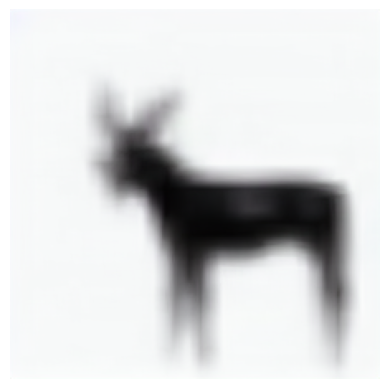

In [110]:



# ============================================================
# 8. Inference (텍스트만 사용)
# ============================================================
unet.eval()
with torch.no_grad():
    captions = "ship"
    dummy_imgs = torch.zeros(1,3,224,224).cuda()  # placeholder
    cond_emb = conditioner(dummy_imgs, captions)

    # Latent 초기화
    latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")

    for t in tqdm(noise_scheduler.timesteps):
        noise_pred = unet(latents, t, encoder_hidden_states=cond_emb).sample
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # 디코딩
    imgs_gen = vae.decode(latents / 0.18215).sample
    imgs_gen = (imgs_gen.clamp(-1,1) + 1) / 2.0

plt.imshow(imgs_gen[0].permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.show()


/tmp/ipython-input-1187092382.py:11: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")
100%|██████████| 1000/1000 [00:40<00:00, 24.54it/s]


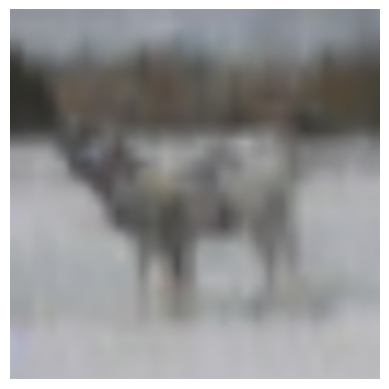

In [81]:


# ============================================================
# 8. Inference (텍스트만 사용)
# ============================================================
unet.eval()
with torch.no_grad():
    captions = ["dog"]
    dummy_imgs = torch.zeros(1,3,224,224).cuda()  # placeholder
    cond_emb = conditioner(dummy_imgs, captions)

    # Latent 초기화
    latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")

    for t in tqdm(noise_scheduler.timesteps):
        noise_pred = unet(latents, t, encoder_hidden_states=cond_emb).sample
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # 디코딩
    imgs_gen = vae.decode(latents / 0.18215).sample
    imgs_gen = (imgs_gen.clamp(-1,1) + 1) / 2.0

plt.imshow(imgs_gen[0].permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.show()


In [51]:
from torch.utils.data import Subset
from collections import defaultdict
from torchvision import datasets, transforms
import torch

# 변환 정의

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# CIFAR-10 로드
cifar10 = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
# airplane(0) ~ truck(9) 전체 클래스
target_classes = list(range(10))   # 0~9 모두
max_per_class = 10                 # 클래스당 샘플 개수

class_counts = defaultdict(int)
selected_indices = []

for idx, (_, label) in enumerate(cifar10):
    if label in target_classes and class_counts[label] < max_per_class:
        selected_indices.append(idx)
        class_counts[label] += 1
    if all(class_counts[c] >= max_per_class for c in target_classes):
        break

# Subset 생성
small_dataset = Subset(cifar10, selected_indices)

# 캡션 생성
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]
captions_all = [f"a photo of a {cifar10_classes[label]}" for _, label in small_dataset]

# DataLoader
loader = DataLoader(list(zip(small_dataset, captions_all)), batch_size=4, shuffle=True)

print(f"총 선택된 데이터 수: {len(small_dataset)}")
print("클래스별 개수:", dict(class_counts))


총 선택된 데이터 수: 20
클래스별 개수: {0: 10, 1: 10}


In [52]:
epochs = 5  # 데이터가 적으니까 여러 번 반복 가능
for epoch in range(epochs):
    for (imgs, labels), captions in tqdm(loader):
        imgs = imgs.cuda()

        # VAE latent
        latents = vae.encode(imgs).latent_dist.sample() * 0.18215

        # 노이즈 추가
        noise = torch.randn_like(latents)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (latents.size(0),), device=latents.device
        ).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Conditioner
        with torch.no_grad():
            cond_emb = conditioner(imgs, captions)

        # U-Net forward
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=cond_emb).sample
        loss = nn.MSELoss()(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f}")


100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


[Epoch 1] Loss: 0.1494


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


[Epoch 2] Loss: 0.1034


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


[Epoch 3] Loss: 0.1532


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


[Epoch 4] Loss: 0.0838


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

[Epoch 5] Loss: 0.0298


In [85]:
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer

class Img2TxtCaptioner(nn.Module):
    def __init__(self, hidden_dim=768, num_queries=16):
        super().__init__()
        self.img_encoder = ImageEncoder(out_dim=hidden_dim)
        self.qformer = QFormer(hidden_dim=hidden_dim, num_queries=num_queries)
        self.proj = nn.Linear(hidden_dim, hidden_dim)

        # GPT-2 with cross-attention
        config = GPT2Config.from_pretrained("gpt2")
        config.add_cross_attention = True   # 🔑 핵심
        self.decoder = GPT2LMHeadModel.from_pretrained("gpt2", config=config)

        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def forward(self, imgs, captions=None):
        img_feat = self.img_encoder(imgs)
        q_feat = self.qformer(img_feat, torch.empty(0, device=imgs.device))
        q_feat = self.proj(q_feat).mean(1)  # (B, D)

        if captions is not None:  # 학습 모드
            tok = self.tokenizer(captions, return_tensors="pt",
                                 padding=True, truncation=True).to(imgs.device)
            outputs = self.decoder(
                input_ids=tok.input_ids,
                attention_mask=tok.attention_mask,
                labels=tok.input_ids,
                encoder_hidden_states=q_feat.unsqueeze(1)
            )
            return outputs.loss
        else:  # 인퍼런스
            input_ids = torch.tensor([[self.tokenizer.bos_token_id]], device=imgs.device)
            generated = self.decoder.generate(
                input_ids=input_ids,
                encoder_hidden_states=q_feat.unsqueeze(1),
                max_length=20
            )
            return [self.tokenizer.decode(g, skip_special_tokens=True) for g in generated]


In [96]:
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from collections import defaultdict

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# CIFAR-10 로드
cifar10 = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
# airplane(0) ~ truck(9) 전체 클래스
target_classes = list(range(10))   # 0~9 모두
max_per_class = 10                 # 클래스당 샘플 개수

class_counts = defaultdict(int)
selected_indices = []

for idx, (_, label) in enumerate(cifar10):
    if label in target_classes and class_counts[label] < max_per_class:
        selected_indices.append(idx)
        class_counts[label] += 1
    if all(class_counts[c] >= max_per_class for c in target_classes):
        break

# Subset 생성
small_dataset = Subset(cifar10, selected_indices)

# 캡션 생성
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]
captions_all = [f"a photo of a {cifar10_classes[label]}" for _, label in small_dataset]

# DataLoader
loader = DataLoader(list(zip(small_dataset, captions_all)), batch_size=4, shuffle=True)

print(f"총 선택된 데이터 수: {len(small_dataset)}")
print("클래스별 개수:", dict(class_counts))



총 선택된 데이터 수: 100
클래스별 개수: {6: 10, 0: 10, 9: 10, 4: 10, 1: 10, 2: 10, 7: 10, 8: 10, 3: 10, 5: 10}


In [97]:
model = Img2TxtCaptioner().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

epochs = 5
for epoch in range(epochs):
    for (imgs, _), captions in tqdm(loader):
        imgs = imgs.cuda()
        loss = model(imgs, captions)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f}")


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

[Epoch 1] Loss: 0.6982


100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


[Epoch 2] Loss: 0.1897


100%|██████████| 25/25 [00:02<00:00,  9.68it/s]


[Epoch 3] Loss: 0.0753


100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


[Epoch 4] Loss: 0.0042


100%|██████████| 25/25 [00:02<00:00,  9.59it/s]

[Epoch 5] Loss: 0.0084


In [92]:
model.eval()
with torch.no_grad():
    test_img, _ = small_dataset[4]  # airplane 하나
    caption = model(test_img.unsqueeze(0).cuda())
    print("Generated:", caption)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated: [' photo of a automobile of a automobile of a automobile of a automobile of a automobile of a automobile']


In [100]:
import torch
from PIL import Image
from torchvision import transforms

# --- 경로 수정 ---
img_path = "/content/airplane.jpg"  # 👉 여기만 바꾸시면 됩니다

# --- 전처리 (CIFAR10과 동일하게 224x224, normalize) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 이미지 불러오기
img = Image.open(img_path).convert("RGB")
img_t = transform(img).unsqueeze(0).cuda()  # (1,3,224,224)

# --- 캡션 생성 ---
model.eval()
with torch.no_grad():
    caption = model(img_t)
    print("Generated Caption:", caption)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Caption: [' photo of a airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane']


/tmp/ipython-input-4180633092.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")
100%|██████████| 1000/1000 [00:41<00:00, 24.18it/s]


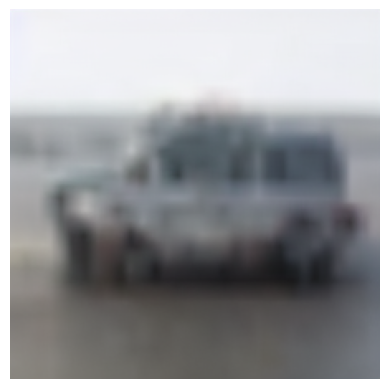

In [105]:
# ============================================================
unet.eval()
with torch.no_grad():
    captions = ["horse"]
    dummy_imgs = torch.zeros(1,3,224,224).cuda()  # placeholder
    cond_emb = conditioner(dummy_imgs, captions)

    # Latent 초기화
    latents = torch.randn((1, unet.in_channels, 224//8, 224//8), device="cuda")

    for t in tqdm(noise_scheduler.timesteps):
        noise_pred = unet(latents, t, encoder_hidden_states=cond_emb).sample
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # 디코딩
    imgs_gen = vae.decode(latents / 0.18215).sample
    imgs_gen = (imgs_gen.clamp(-1,1) + 1) / 2.0

plt.imshow(imgs_gen[0].permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.show()

In [ ]:

from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="scheduler"
)
noise_scheduler.set_timesteps(50)  # 50 steps로 제한
